# Causal discovery with `TIGRAMITE` depicting synergistic variables


In [1]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn
import sys
sys.path.append('./../')
sys.path.append('./../../')

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, RobustParCorr, ParCorrWLS, GPDC, CMIknn, CMIknnMixed, CMIsymb, Gsquared, RegressionCI

In [2]:
def generate_discrete_noise(num_classes, num_samples, snr=0.9):
    avg_noise = (1 - snr) / num_classes
    probs = [snr] + [avg_noise for _ in range(num_classes)]
    bins = np.add.accumulate(probs)
    return np.digitize(np.random.random_sample(num_samples), bins)

In [11]:
def get_two_var_data(T, p=0.2, snr=0.8, seed=1):
    random_state = np.random.default_rng(seed)
    
    temp_high = random_state.binomial(n=1, p=p, size=(T, 1))
    prec_high = random_state.binomial(n=1, p=p, size=(T, 1))
    # discrete noise for fire
    fire_noise = np.expand_dims(generate_discrete_noise(1, T, snr=snr), axis=-1)
    for t in range(T):
        fire = np.mod(np.logical_and(temp_high, prec_high) + fire_noise, 2)
    data = np.concatenate([temp_high, prec_high, fire], axis=-1)
    return data

In [16]:
def run_pcmci_cmi(dataframe, sig_samples=100, estimator='MS'):
    cmimixed = CMIknnMixed(sig_samples=sig_samples, estimator=estimator)
    pcmci_cmi = PCMCI(
        dataframe=dataframe, 
        cond_ind_test=cmimixed)
    results = pcmci_cmi.run_pcalg_non_timeseries_data(pc_alpha=0.05)
    val_matrix = results['val_matrix']
    # val_matrix /= (2.*T)
    
    return val_matrix, results

In [6]:
def plot(val_matrix, val_results, var_names):
    tp.plot_graph(
    val_matrix=val_matrix,
    graph=val_results['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    vmin_edges=0.,
    vmax_edges = 0.3,
    edge_ticks=0.05,
    cmap_edges='OrRd',
    vmin_nodes=0,
    vmax_nodes=.5,
    node_ticks=.1,
    cmap_nodes='OrRd',
    ); plt.show()

In [7]:
T = 1000

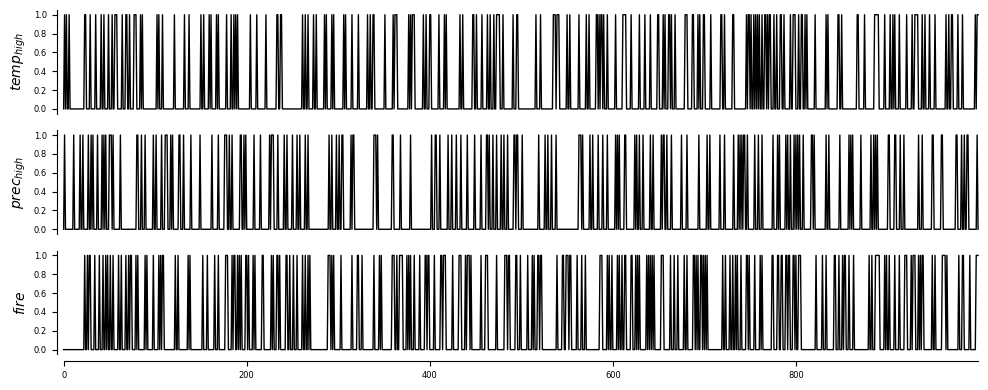

In [14]:
two_data = get_two_var_data(T, p=0.2, snr=0.8)
two_dataframe = pp.DataFrame(two_data, 
                             var_names=[r'$temp_{high}$', r'$prec_{high}$', r'$fire$'], 
                             type_mask=np.ones(two_data.shape))
tp.plot_timeseries(two_dataframe, figsize=(10,4)); plt.show()

In [17]:
two_matrix, two_results = run_pcmci_cmi(two_dataframe, sig_samples=100, estimator='MS')

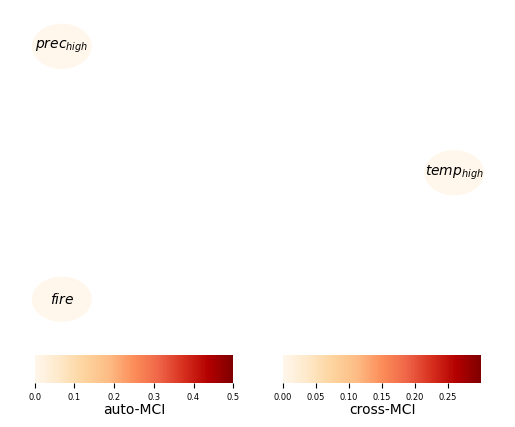

In [19]:
plot(two_matrix, two_results, [r'$temp_{high}$', r'$prec_{high}$', r'$fire$'])

In [20]:
# twos_data = get_two_var_data(T, p=0.2, snr=0.8)
twos_dataframe = pp.DataFrame(two_data, 
                              type_mask=np.ones(two_data.shape), 
                              var_names=[r'$temp_{high} & prec_{high}$', r'$fire$'], 
                              vector_vars={0: [(0, 0), (1, 0)], 1: [(2, 0)]})


In [21]:
twos_matrix, twos_results = run_pcmci_cmi(twos_dataframe, sig_samples=100, estimator='MS')

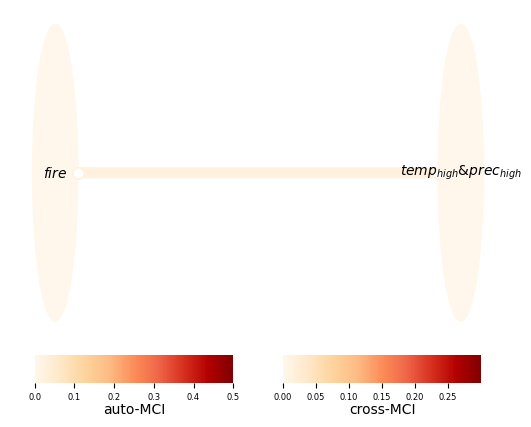

In [24]:
plot(twos_matrix, twos_results, [r'$temp_{high} & prec_{high}$', r'$fire$'])

In [42]:
def get_three_var_data(T, p=0.2, snr=0.8, seed=1):
    random_state = np.random.default_rng(seed)
    
    temp_high = random_state.binomial(n=1, p=p, size=(T, 1))
    prec_high = random_state.binomial(n=1, p=p, size=(T, 1))
    season = random_state.binomial(n=1, p=1. - p, size=(T, 1))
    
    # discrete noise for fire
    fire_noise = np.expand_dims(generate_discrete_noise(1, T, snr=snr), axis=-1)
    
    for t in range(T):
        fire = np.mod(np.logical_and(np.logical_and(temp_high, prec_high), season) + fire_noise, 2)
    data = np.concatenate([temp_high, prec_high, prec_high, fire], axis=-1)
    return data

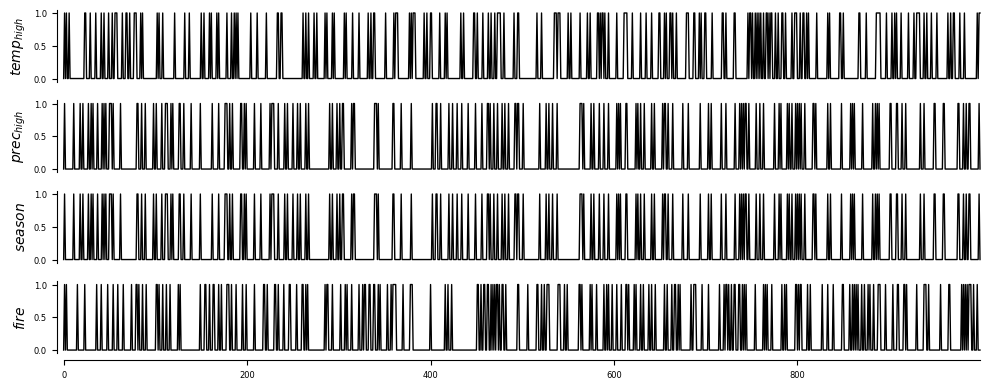

In [43]:
three_data = get_three_var_data(T, p=0.2, snr=0.8)
three_dataframe = pp.DataFrame(three_data, 
                               type_mask=np.ones(three_data.shape),
                               var_names=[r'$temp_{high}$', '$prec_{high}$', '$season$', r'$fire$'])
tp.plot_timeseries(three_dataframe, figsize=(10,4)); plt.show()

In [44]:
three_matrix, three_results = run_pcmci_cmi(three_dataframe)

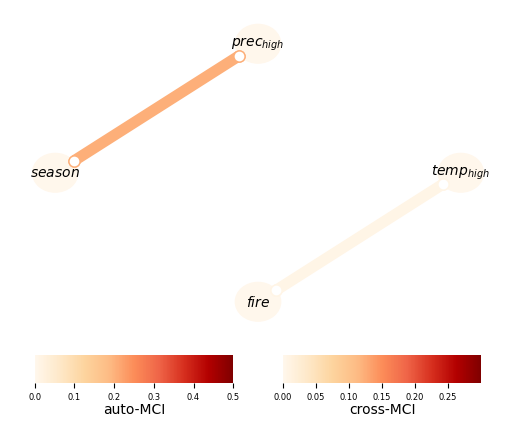

In [45]:
plot(three_matrix, three_results, [r'$temp_{high}$', r'$prec_{high}$', r'$season$', r'$fire$'])

In [46]:
threes_dataframe = pp.DataFrame(three_data,
                                type_mask=np.ones(three_data.shape),
                                var_names=[r'$temp_{high} & prec_{high} & season $', r'$fire$'],
                                vector_vars={0:[(0,0), (1, 0), (2, 0)], 1:[(3, 0)]})


In [47]:
threes_matrix, threes_results = run_pcmci_cmi(threes_dataframe)

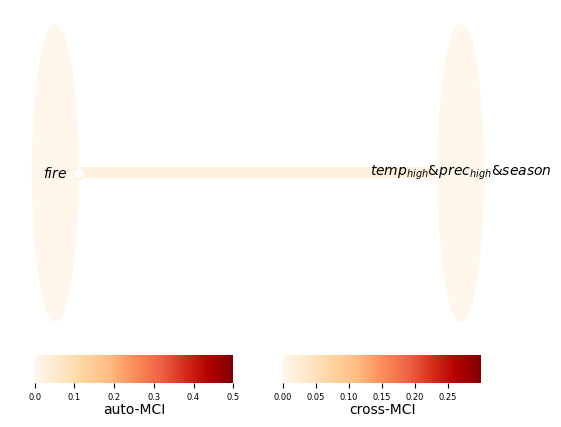

In [48]:
plot(threes_matrix, threes_results, [r'$temp_{high} & prec_{high} & season$', r'$fire$'])